In [177]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from methods.mmca_threshold import MMCA_threshold
from methods import mmca
from methods.utils import dynamic

from joblib import Parallel, delayed
from parameters import Initial_data
device = torch.device('cpu')

In [38]:
# 导入默认参数
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'parameters/inital_data_1.pkl')
with open(file_path, 'rb') as f:
    init_data = pickle.load(f)

epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
node_num = epi_paras.shape[0]

In [39]:
Player, Ilayer= 'ucm1', 'ucm1'

In [ ]:
para_len = 20
soc_paras_sigma_mu = soc_paras.unsqueeze(0).repeat(1, 1)
epi_paras_sigma_mu = epi_paras.unsqueeze(0).repeat(1, 1, 1)

epi_paras_sigma_mu[...,3] = 0.08
#  替换掉自己的参数
P_gamma = torch.linspace(2.0, 3.0, para_len)
I_gamma = torch.linspace(2.0, 3.0, para_len)


mmca_threshold = MMCA_threshold()
P_I_threshold = torch.zeros(P_gamma.shape[0], I_gamma.shape[0])

init_pA =  torch.rand(1, node_num).to(device)
max_iter = 1000
tol = 1e-16
process = 0

def job_fun(i,j,P_gamma, I_gamma):
    sample_len = 100
    beta_c = 0
    for k in range(sample_len):
        P_matrix = Initial_data.generate_graph(node_num, Player, ucm_gamma = P_gamma,\
                                            seed = i*k, conk= 4.0)
        I_matrix = Initial_data.generate_graph(node_num, Ilayer, ucm_gamma = I_gamma,\
                                                    seed = j*k, conk= 5.0)

        I_rows, I_cols = I_matrix.nonzero()
        I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)

        p_A = mmca_threshold.iteration(max_iter, tol, init_pA, epi_paras_sigma_mu, soc_paras_sigma_mu,\
                                            I_edge_index)
        beta_mu_3 = mmca_threshold.degree_MCMC_threshold(p_A, epi_paras_sigma_mu, soc_paras_sigma_mu, P_matrix)
        beta_c += beta_mu_3
    beta_c = beta_c / sample_len
    return i, j, beta_c

# P_gamma, I_gamma = 3.0,3.0
# _,_,beta_mu_3 = job_fun(1,1,P_gamma, I_gamma)

results = Parallel(n_jobs=20)(
    delayed(job_fun)(i, j, P_gamma[i], I_gamma[j])
    for i in range(P_gamma.shape[0])
    for j in range(I_gamma.shape[0])
)

for i, j, beta_mu_3 in results:
    P_I_threshold[i, j] = beta_mu_3
    
torch.save(P_I_threshold,'data/P_I_threshold.pt')

C:\Users\95406\AppData\Local\Temp\ipykernel_2024\1955489641.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  P_I_threshold = torch.load('data/P_I_threshold.pt')


tensor(-2.0284)
tensor(-1.6333)


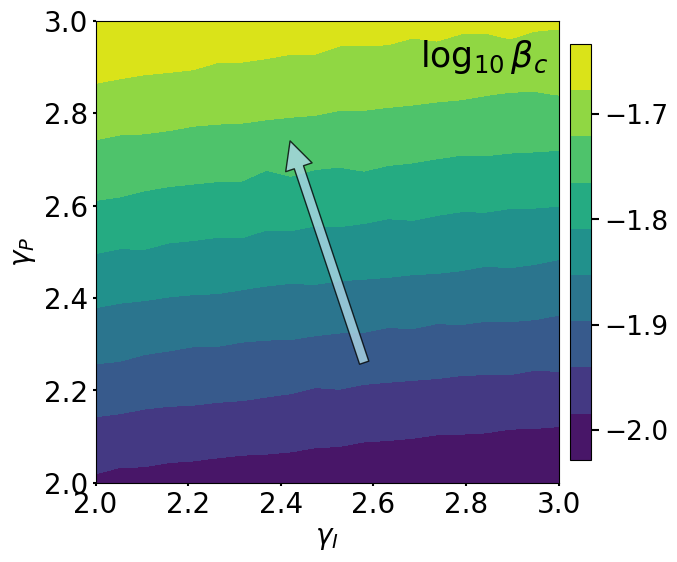

In [165]:

P_I_threshold = torch.load('data/P_I_threshold.pt')

# 绘制相图
plt.figure(figsize=(7.2, 6))  # 设置图像大小
# 使用 sigma_values 和 mu_values 作为横纵坐标
X, Y = np.meshgrid(I_gamma, P_gamma)

vmin = torch.min(torch.log10(P_I_threshold))
vmax = torch.max(torch.log10(P_I_threshold))

print(vmin)
print(vmax)

plt.contourf(X, Y, torch.log10(P_I_threshold), levels=np.linspace(vmin, vmax, 10), cmap='viridis', origin='lower')  # 填充等高线图

cbar = plt.colorbar( orientation='vertical', shrink=0.9, pad=0.02)  # 添加颜色条
cbar.set_ticks(np.linspace(-2.0, -1.7, 4))
# cbar.set_label(r'$\log \beta_c$', fontsize=15) 
cbar.ax.tick_params(labelsize=19, length=6, width=1.5)

# plt.xscale('log')
# plt.yscale('log')

# plt.annotate('', xytext=(2.8, 2.2), xy=(2.2, 2.8),
#             arrowprops=dict(facecolor='', shrink=0.2))
plt.annotate('', xy=(2.4, 2.8), xytext=(2.6, 2.2),
            arrowprops=dict(connectionstyle='arc3',width=7, headwidth=20, headlength=20,
                             shrink=0.1, fc='lightblue', ec='black', alpha=0.8))


plt.ylabel(r'$\gamma_P$', fontsize=20)  # X轴标签
plt.xlabel(r'$\gamma_I$', fontsize=20)  # Y轴标签
plt.tick_params(axis='both', which='major', labelsize=20, length=2, width=1.5)
plt.text(2.7, 2.9, r'$\log_{10} \beta_{c}$', fontsize=25, color='black')
# plt.text(0.012, 0.7, 'UCM-UCM', fontsize=25, color='black')

# 添加箭头
# plt.annotate('', xy=(0.05, 0.1), xytext=(0.05, 0.004),
#             arrowprops=dict(connectionstyle='arc3',width=7, headwidth=20, headlength=20,
#                              shrink=0.1, fc='lightblue', ec='black', alpha=0.8))
# plt.text(0.02, 0.1, 'More infection', fontsize=20, color='black')

# plt.show()
plt.savefig(f'../figs/NetworkStructure/p_I_threshold_ucm.svg', bbox_inches='tight')
plt.savefig(f'../figs/NetworkStructure/p_I_threshold_ucm.png', dpi=600)

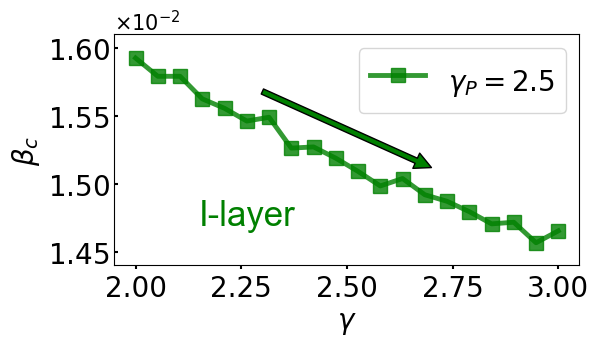

In [163]:
index_lam = 10
# lam 可视化
data2 = P_I_threshold[index_lam]

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(I_gamma, data2, color='green', linewidth=3.5, linestyle='-',
          marker='s', markersize=10, alpha=0.8, label = r'$\gamma_P = $' + f'{P_gamma[index_lam]:.1f}')



# 添加箭头
ax.annotate('', xy=(3, 0.0147), xytext=(2, 0.0161),
            arrowprops=dict(facecolor='green', shrink=0.3))

# 添加文本标签
ax.text(2.15, 0.0147, 'I-layer', fontsize=25, color='green',
        fontdict={'family': 'Arial', 'weight': 'normal', 'style': 'normal'})


# 设置坐标轴标签
ax.set_xlabel(r'$\gamma$', fontsize=20, color='black')
ax.set_ylabel(r'$\beta_c$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
# ax.set_xlim(0, 1)
ax.set_ylim( 0.0144,0.0161)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# 设置纵坐标为科学计数法，并使用 LaTeX 风格
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))  # 对所有数值使用科学计数法
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.get_offset_text().set_fontsize(15)

ax.legend(fontsize=20, handlelength=2, handleheight=2)
# 显示图形
plt.show()

fig.savefig(f'../figs/NetworkStructure/I_beta.svg', bbox_inches='tight')

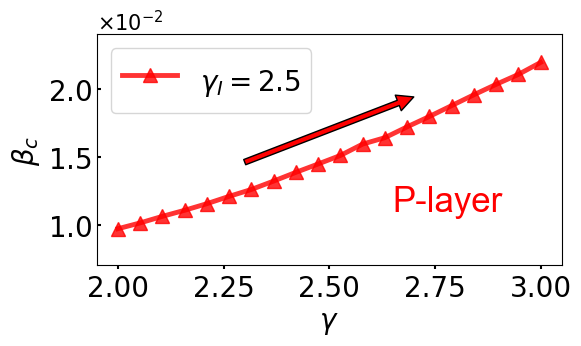

In [145]:
index_lam = 10
# lam 可视化
data1 = P_I_threshold[:,index_lam]

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(I_gamma, data1, color='red', linewidth=3.5, linestyle='-',
          marker='^', markersize=10, alpha=0.8, label = r'$\gamma_I = $' + f'{I_gamma[index_lam]:.1f}')

# 添加箭头
ax.annotate('', xy=(3, 0.023), xytext=(2, 0.011),
            arrowprops=dict(facecolor='red', shrink=0.3))

# 添加文本标签
ax.text(2.65, 0.011, 'P-layer', fontsize=25, color='red',
        fontdict={'family': 'Arial', 'weight': 'normal', 'style': 'normal'})

# 设置坐标轴标签
ax.set_xlabel(r'$\gamma$', fontsize=20, color='black')
ax.set_ylabel(r'$\beta_c$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
# ax.set_xlim(0, 1)
ax.set_ylim( 0.007,0.024)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# 设置纵坐标为科学计数法，并使用 LaTeX 风格
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))  # 对所有数值使用科学计数法
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.get_offset_text().set_fontsize(15)

ax.legend(fontsize=20, handlelength=2, handleheight=2)
# 显示图形
plt.show()

fig.savefig(f'../figs/NetworkStructure/P_beta.svg', bbox_inches='tight')

In [ ]:
para_len = 10
soc_paras_obs = soc_paras.unsqueeze(0).repeat(1, 1)
epi_paras_obs = epi_paras.unsqueeze(0).repeat(1, 1, 1)

#  替换掉自己的参数
P_gamma = torch.linspace(2.0, 3.0, para_len)
I_gamma = torch.linspace(2.0, 3.0, para_len)

delta_t = 0.1
time_scale = int(50/delta_t)
mmca_method = mmca.MMCA(device)
features_prob = torch.tensor(init_data['init_prob'], dtype=torch.float32).to(device)
features_prob_tensor = features_prob.unsqueeze(0).repeat(1, 1, 1).to(device)

P_I_steadystate = torch.zeros(P_gamma.shape[0], I_gamma.shape[0])

def job_fun(i,j, P_gamma, I_gamma):
    sample_len = 1
    steadystate = 0
    for k in range(sample_len):
        P_matrix = Initial_data.generate_graph(node_num, Player, ucm_gamma = P_gamma,\
                                            seed = i*k, conk= 4.0)
        I_matrix = Initial_data.generate_graph(node_num, Ilayer, ucm_gamma = I_gamma,\
                                                    seed = j*k, conk= 5.0)
        
        P_rows, P_cols = P_matrix.nonzero()
        P_edge_index = torch.tensor(np.array([P_rows, P_cols]), dtype=torch.long).to(device)
        I_rows, I_cols = I_matrix.nonzero()
        I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)

        features_times_mmca, _ = dynamic(time_scale, mmca_method, features_prob_tensor.clone(), epi_paras_obs,\
                                                   soc_paras_obs, P_edge_index, I_edge_index, device, obs = 1)
        steadystate += torch.sum(features_times_mmca[:,-1,:][:,[2,3,4]])
    steadystate = steadystate/sample_len
    return i, j, steadystate


results = Parallel(n_jobs=20)(
    delayed(job_fun)(i, j, P_gamma[i], I_gamma[j])
    for i in range(P_gamma.shape[0])
    for j in range(I_gamma.shape[0])
)

for i, j, steadystate in results:
    P_I_steadystate[i, j] = steadystate
    
torch.save(P_I_steadystate,'data/P_I_steadystate.pt')

tensor(-0.4770)
tensor(-0.2936)


C:\Users\95406\AppData\Local\Temp\ipykernel_2024\1464542461.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  P_I_steadystate = torch.load('data/P_I_steadystate.pt')


Text(2.7, 2.9, '$\\log_{10} p^{EI}$')

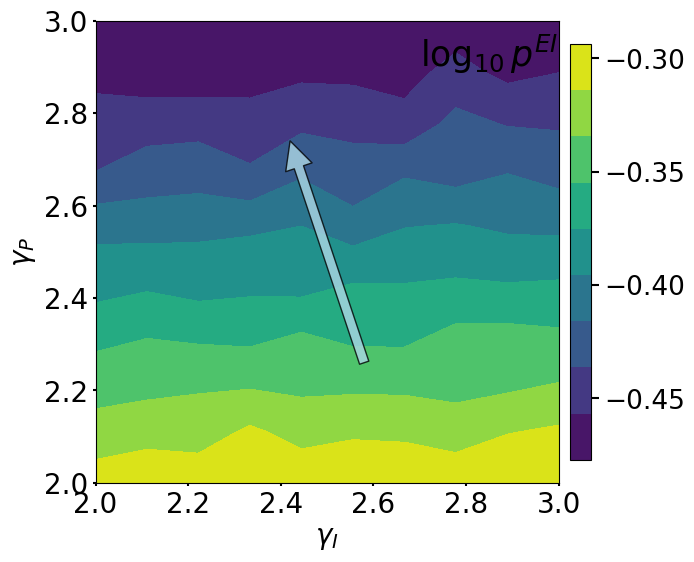

In [183]:

P_I_steadystate = torch.load('data/P_I_steadystate.pt')

# 绘制相图
plt.figure(figsize=(7.2, 6))  # 设置图像大小
# 使用 sigma_values 和 mu_values 作为横纵坐标
X, Y = np.meshgrid(I_gamma, P_gamma)

vmin = torch.min(torch.log10(P_I_steadystate))
vmax = torch.max(torch.log10(P_I_steadystate))

print(vmin)
print(vmax)

plt.contourf(X, Y, torch.log10(P_I_steadystate), levels=np.linspace(vmin, vmax, 10), cmap='viridis', origin='lower')  # 填充等高线图

cbar = plt.colorbar( orientation='vertical', shrink=0.9, pad=0.02)  # 添加颜色条
cbar.set_ticks(np.linspace(-0.3, -0.45, 4))
# cbar.set_label(r'$\log \beta_c$', fontsize=15) 
cbar.ax.tick_params(labelsize=19, length=6, width=1.5)

# plt.xscale('log')
# plt.yscale('log')

# plt.annotate('', xytext=(2.8, 2.2), xy=(2.2, 2.8),
#             arrowprops=dict(facecolor='', shrink=0.2))
plt.annotate('', xy=(2.4, 2.8), xytext=(2.6, 2.2),
            arrowprops=dict(connectionstyle='arc3',width=7, headwidth=20, headlength=20,
                             shrink=0.1, fc='lightblue', ec='black', alpha=0.8))


plt.ylabel(r'$\gamma_P$', fontsize=20)  # X轴标签
plt.xlabel(r'$\gamma_I$', fontsize=20)  # Y轴标签
plt.tick_params(axis='both', which='major', labelsize=20, length=2, width=1.5)
plt.text(2.7, 2.9, r'$\log_{10} p^{EI}$', fontsize=25, color='black')


# # plt.show()
# plt.savefig(f'../figs/NetworkStructure/p_I_steadystate_ucm.svg', bbox_inches='tight')
# plt.savefig(f'../figs/NetworkStructure/p_I_steadystate_ucm.png', dpi=600)